# Starter Code for the pawpularity data

**NOTE** Better choose a GPU Instance for runtime

This notebook is a starter code for the pawpularity data. The data is about predicting the popularity of a pet given its image. The data is taken from the Kaggle competition [PetFinder.my - Pawpularity Contest](https://www.kaggle.com/c/petfinder-pawpularity-score).

## The Usual Libraries

In [ ]:
import os
################## Keras with PyTorch Backend ################
# Set Keras backend to PyTorch
# os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1" #Needed on MAC to avoid MPS error (22 Nov 2024)
os.environ["KERAS_BACKEND"] = "torch" # Before importing Keras!
import torch
from torch.distributions import Normal
cuda_available = torch.cuda.is_available()
cuda_version = torch.version.cuda if cuda_available else "N/A"
print(f"CUDA Available: {cuda_available}")
print(f"CUDA Version: {cuda_version}")

import keras
print(keras.__version__)
print(f"Keras version: {keras.__version__}")
print(f"Backend: {keras.backend.backend()}")

CUDA Available: True
CUDA Version: 12.4
3.8.0
Keras version: 3.8.0
Backend: torch


In [ ]:
### Usual keras imports
from keras import layers, Input, Model
from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten , Activation, Dropout, Input, Concatenate
import keras.backend as K

## Loading the data

The data is from the following Kaggle Competition
https://www.kaggle.com/competitions/petfinder-pawpularity-*score*

In [ ]:
##### Libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import time
import os
%matplotlib inline
from scipy import misc

In [ ]:
# Loading the data, if it does not exist, this will take some time (Colab about 30 sec)
import urllib
import os
if not os.path.isfile('petfinder-pawpularity-score.zip'):
    urllib.request.urlretrieve("https://www.dropbox.com/scl/fi/of8dxl0eb9y0c81o0rzhn/petfinder-pawpularity-score.zip?rlkey=5zxcpsc7x6jk74q8a4b5sloo7&dl=1",
                               "petfinder-pawpularity-score.zip")
!ls -lh petfinder-pawpularity-score.zip
!unzip -q -n petfinder-pawpularity-score.zip
!ls -l train | wc -l #Number of Training data

-rw-r--r-- 1 root root 983M Jan 30 15:01 petfinder-pawpularity-score.zip
9913


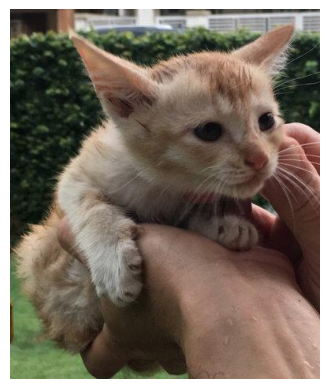

In [ ]:
def display_image(image_path):
  try:
    image = imgplot.imread(image_path)
    plt.imshow(image)
    plt.axis('off')  # Hide axes
    plt.show()
  except FileNotFoundError:
    print(f"Error: Image file not found at {image_path}")
  except Exception as e:
    print(f"An error occurred: {e}")

image_path = 'train/0a0da090aa9f0342444a7df4dc250c66.jpg'
display_image(image_path)

In [ ]:
import pandas as pd
df = pd.read_csv('train.csv')
df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [ ]:
# Add column with filepath from the id
df['path'] = df['Id'].map(lambda x: os.path.join('train', str(x) + '.jpg'))
df = df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,path
0,2a9bc1087df9c3246667a6f8da897c88,0,1,1,1,0,0,0,0,0,0,1,0,42,train/2a9bc1087df9c3246667a6f8da897c88.jpg
1,295f993b591bf42f601d0a3e98b926da,0,1,1,1,0,0,0,0,0,0,0,0,79,train/295f993b591bf42f601d0a3e98b926da.jpg
2,600030efe4b0f414769832f5baeef82c,0,1,1,1,0,0,0,0,1,1,0,0,66,train/600030efe4b0f414769832f5baeef82c.jpg
3,302839658218b3fcec6cbc5046ef3bd7,0,0,0,1,0,0,0,0,0,0,0,1,22,train/302839658218b3fcec6cbc5046ef3bd7.jpg
4,cbe81e7b3a15e51e8b5fdd18967e6cb9,0,1,1,1,0,0,0,0,0,0,0,0,63,train/cbe81e7b3a15e51e8b5fdd18967e6cb9.jpg


In [ ]:
# Normalize the score
df['norm_score'] = df['Pawpularity']/100

There are 9912 images


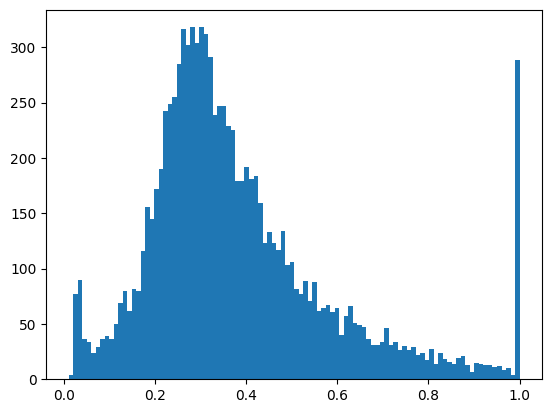

In [ ]:
len_df = len(df)
print(f"There are {len_df} images")
plt.hist(df['norm_score'], bins=100)
plt.show()

In [ ]:
# prompt: Fit a 0 model using mean and calculate RMSE

import numpy as np

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

# Assuming 'df' is your DataFrame as defined in the provided code
y_true = df['norm_score'].values
y_pred_mean = np.full(len(y_true), np.mean(y_true))

rmse_0_model = rmse(y_pred_mean, y_true)
print(f"RMSE of the 0 model (mean): {rmse_0_model}")

RMSE of the 0 model (mean): 0.2059095133915306


In [ ]:
# prompt: Lade ein auf Image Net vor trainiertes VGGNet und benutze es zur Feature Extraction für diesen Datensatz und benutze die Feature in einem random Forrest um die Cuteness vorherzusagen. Verwende so wie sonst in dem NB Keras mit torch

import os
import torch
from torch.distributions import Normal
import keras
from keras import layers, Input, Model
from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten , Activation, Dropout, Input, Concatenate
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import time
from scipy import misc
import urllib
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from keras.layers import GlobalAveragePooling2D

# Load pre-trained VGGNet (replace with your preferred architecture)
from keras.applications.vgg16 import VGG16
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = vgg_model.output
x = GlobalAveragePooling2D()(x)  # Convert (7,7,512) → (1,1,512)
model = Model(inputs=vgg_model.input, outputs=x)

# Feature extraction
def extract_features(image_path):
    try:
        img = Image.open(image_path).resize((224, 224))
        img_array = np.array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0) # Add batch dimension for keras
        features = model.predict(img_array, verbose=0)#vgg_model.predict(img_array)
        return features.flatten()
    except FileNotFoundError:
        print(f"Error: Image file not found at {image_path}")
        return None
    except Exception as e:
        print(f"An error occurred during feature extraction: {e}")
        return None

# Limit to 300 rows
#df_subset = df.head(300)

features = []
for index, row in df.iterrows():
    feature = extract_features(row['path'])
    if (index % 100 == 0):
      print(f"Processed {index} images")
    if feature is not None:
      features.append(feature)
    else:
      # Handle cases where feature extraction fails (e.g., skip image)
      print(f"Skipping image at index {index} due to feature extraction error")

X = np.array(features)
y = df['norm_score'].values


Processed 0 images
Processed 100 images
Processed 200 images
Processed 300 images
Processed 400 images
Processed 500 images
Processed 600 images
Processed 700 images
Processed 800 images
Processed 900 images
Processed 1000 images
Processed 1100 images
Processed 1200 images
Processed 1300 images
Processed 1400 images
Processed 1500 images
Processed 1600 images
Processed 1700 images
Processed 1800 images
Processed 1900 images
Processed 2000 images
Processed 2100 images
Processed 2200 images
Processed 2300 images
Processed 2400 images
Processed 2500 images
Processed 2600 images
Processed 2700 images
Processed 2800 images
Processed 2900 images
Processed 3000 images
Processed 3100 images
Processed 3200 images
Processed 3300 images
Processed 3400 images
Processed 3500 images
Processed 3600 images
Processed 3700 images
Processed 3800 images
Processed 3900 images
Processed 4000 images
Processed 4100 images
Processed 4200 images
Processed 4300 images
Processed 4400 images
Processed 4500 images


In [ ]:
X.shape

(9912, 512)

In [ ]:
# prompt: Store the data X and y in a gz.csv file so that it can be loaded into R and give the R code in the comments

import pandas as pd
import numpy as np

# Assuming X and y are already defined as in the previous code

# Create a DataFrame
df_data = pd.DataFrame(X)
df_data['target'] = y

# Save to a compressed CSV file
df_data.to_csv('data.gz.csv', compression='gzip', index=False)


# R code to load the data:
# library(readr)
# data <- read_csv("data.gz.csv", col_names = TRUE)
# X <- data[,1:(ncol(data) -1)] # select all columns except target
# y <- data$target